In [ ]:
!pip install scikit-learn pandas matplotlib numpy seaborn 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV




In [49]:
df = pd.read_csv('city_day.csv', low_memory= False) 

df['Date'] = pd.to_datetime(df['Date'])


# Extract datetime features to numeric values.
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
#df['Hour'] = df['Date'].dt.hour

# cant have Nan values in target variable
df = df.dropna(subset=['O3'])
print(df.head())


        City       Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad 2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad 2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad 2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad 2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad 2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  Year  Month  Day  
0  133.36     0.00     0.02    0.00  NaN        NaN  2015      1    1  
1   34.06     3.68     5.50    3.77  NaN        NaN  2015      1    2  
2   30.70     6.80    16.40    2.25  NaN        NaN  2015      1    3  
3   36.08     4.43    10.14    1.00  NaN        NaN  2015      1    4  
4   39.31     7.01    18.89    2.78  NaN        NaN  2015      1    5  


In [50]:
X = df.drop(['AQI_Bucket', 'Date', 'City', 'O3'] , axis=1)
print(X.head())
y = df['O3']
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)


   PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  Benzene  Toluene  \
0    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64     0.00     0.02   
1    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55     3.68     5.50   
2    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07     6.80    16.40   
3    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59     4.43    10.14   
4    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33     7.01    18.89   

   Xylene  AQI  Year  Month  Day  
0    0.00  NaN  2015      1    1  
1    3.77  NaN  2015      1    2  
2    2.25  NaN  2015      1    3  
3    1.00  NaN  2015      1    4  
4    2.78  NaN  2015      1    5  
0    133.36
1     34.06
2     30.70
3     36.08
4     39.31
Name: O3, dtype: float64


Parameter search
Using halving grid search due to high processing for normal grid search.

In [ ]:
param_grid = {
    'max_features': [0.2, 0.4, 0.6, 0.8, 1, 'sqrt', 'log2'],
    'max_samples': np.arange(0.2, 1.0, 0.2),
    'max_depth': [5, 15, 25, None]

}

grid = HalvingGridSearchCV(
    estimator=RandomForestRegressor(n_estimators=100, random_state=1),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    return_train_score=True,
    verbose =2
)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best Score:", -grid.best_score_)


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 236
max_resources_: 19131
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 96
n_resources: 236
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 1
n_candidates: 32
n_resources: 708
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 2
n_candidates: 11
n_resources: 2124
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 3
n_candidates: 4
n_resources: 6372
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 19116
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'max_depth': None, 'max_features': 0.6, 'max_samples': np.float64(0.8)}
Best Score: 154.0479402145242


Fit regressor:

In [52]:
regr = RandomForestRegressor(n_estimators=100, oob_score = True, max_features= 0.6, max_samples= 0.8)

regr.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [53]:
oob_score = regr.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

predictions = regr.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.6820741640610715
Mean Squared Error: 148.93333730604576
R-squared: 0.6910690654767624


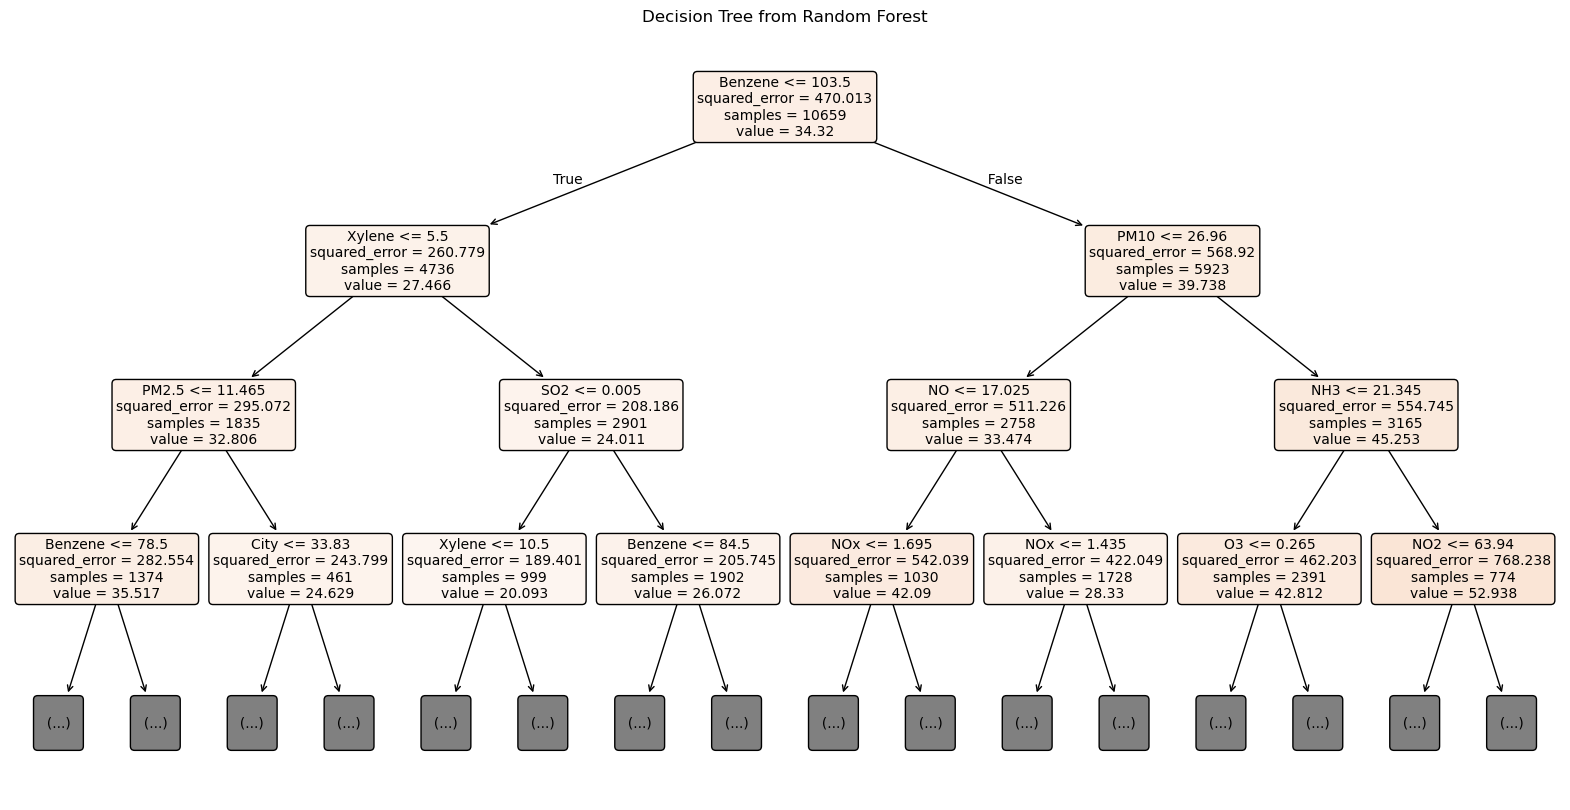

In [55]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_to_plot = regr.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, max_depth = 3, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree from Random Forest")
plt.show()

Text(0.5, 1.0, 'Feature Importances from Random Forest')

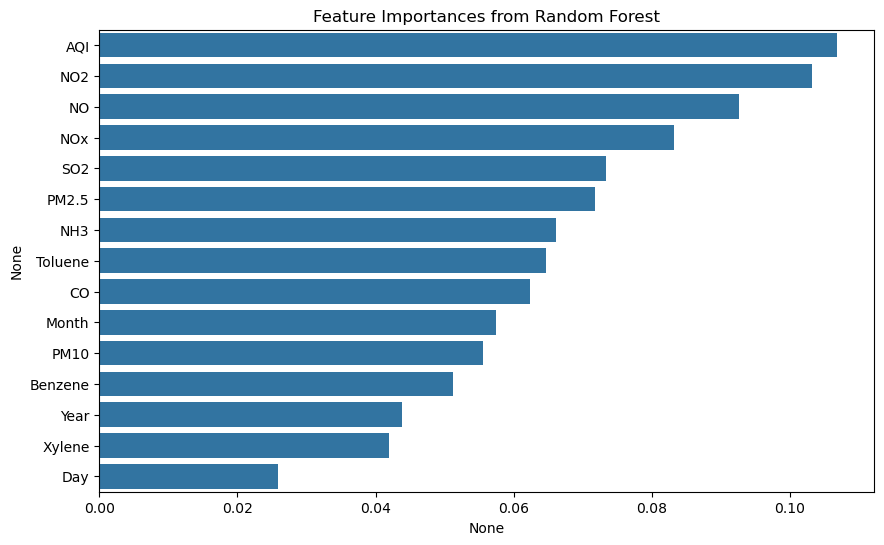

In [56]:
importances = regr.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances from Random Forest')

In [22]:
from sklearn.model_selection import KFold 

In [25]:
df = pd.read_csv('city_day.csv', low_memory= False) 

df['Date'] = pd.to_datetime(df['Date'])


# Extract datetime features to numeric values.
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
#df['Hour'] = df['Datetime'].dt.hour

# cant have Nan values in target variable
df = df.dropna(subset=['O3'])
print(df.head())

X = df.drop(['AQI_Bucket', 'Date', 'City', 'O3'] , axis=1)
print(X.head())
y = df['O3']
print(y.head())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


        City       Date  PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  \
0  Ahmedabad 2015-01-01    NaN   NaN   0.92  18.22  17.15  NaN   0.92  27.64   
1  Ahmedabad 2015-01-02    NaN   NaN   0.97  15.69  16.46  NaN   0.97  24.55   
2  Ahmedabad 2015-01-03    NaN   NaN  17.40  19.30  29.70  NaN  17.40  29.07   
3  Ahmedabad 2015-01-04    NaN   NaN   1.70  18.48  17.97  NaN   1.70  18.59   
4  Ahmedabad 2015-01-05    NaN   NaN  22.10  21.42  37.76  NaN  22.10  39.33   

       O3  Benzene  Toluene  Xylene  AQI AQI_Bucket  Year  Month  Day  
0  133.36     0.00     0.02    0.00  NaN        NaN  2015      1    1  
1   34.06     3.68     5.50    3.77  NaN        NaN  2015      1    2  
2   30.70     6.80    16.40    2.25  NaN        NaN  2015      1    3  
3   36.08     4.43    10.14    1.00  NaN        NaN  2015      1    4  
4   39.31     7.01    18.89    2.78  NaN        NaN  2015      1    5  
   PM2.5  PM10     NO    NO2    NOx  NH3     CO    SO2  Benzene  Toluene  \
0    NaN   

In [28]:
# Random forest classifier


def hyperparamerter_forest():
    
    # initialse kfold
    kf = KFold(n_splits=5)
    
    # hyperparameters to tune: max_features and max_samples
    m_choices = [0.2, 0.4, 0.6, 0.8, 'sqrt', 'log2']
    sample_choices = np.arange(0.2, 1, 0.2)
    
    print('Choices of the maximum number of features:', m_choices)
    print('Choices of the maximum number of samples:', sample_choices)

    # creating arrays to store accuracy
    forest_train_acc = np.zeros((len(m_choices), len(sample_choices), 5))
    forest_val_acc = np.zeros((len(m_choices), len(sample_choices), 5))

    for i, (train_index, test_index) in enumerate(kf.split(X_train)):

        # create i'th folds and split into train and validation
        X_train_fold = X_train.iloc[train_index]
        y_train_fold = y_train.iloc[train_index]
        X_val_fold = X_train.iloc[test_index]
        y_val_fold = y_train.iloc[test_index]

        print(f'Fitting fold {i+1}...')

        
        # iterating over max features
        for j in range(len(m_choices)):

            # selecting m
            m = m_choices[j]  

            for k in range(len(sample_choices)):
                
                sample = sample_choices[k]
                # initialise random forest classifer
                model = RandomForestRegressor(n_estimators=100, max_features=m, max_samples=sample, random_state=1)
                
                # fitting model
                model.fit(X_train_fold, y_train_fold)
                
                # predicting classes of training data
                forest_pred_train = model.predict(X_train_fold)
                
                # predicting classes of validation data
                forest_pred_val = model.predict(X_val_fold)

                # calculate accuracies
                forest_train_acc[j, k, i] = mean_squared_error(y_train_fold, forest_pred_train)
                forest_val_acc[j, k, i] = mean_squared_error(y_val_fold, forest_pred_val)

    # Get the average ACCs across 5-folds
    forest_train_acc_avg = forest_train_acc.mean(axis=2)
    forest_val_acc_avg = forest_val_acc.mean(axis=2)

    # finds the index corresponding to the best accuracy
    idx = np.argmin(forest_val_acc_avg)

    # finds the position in the matrix corresponding the index
    best_combination = np.unravel_index(idx , forest_val_acc_avg.shape)
    # uses position to find best max samples and max samples
    m_best_forest = m_choices[best_combination[0]]
    best_sample = sample_choices[best_combination[1]]
    print(f'Best Max number of Features: {m_best_forest}')
    print(f'Best Max Samples: {best_sample:.2f}')

    # returns optimum pair of value of max features and max samples

    return m_best_forest, best_sample



def random_forest(m, s):

    # initialise forest classifier
    model = RandomForestRegressor(n_estimators=100, max_features=m, max_samples= s, random_state =1)
    # fit using all train data subset
    model.fit(X_train, y_train)
    # predcit on test subset
    y_pred_forest = model.predict(X_test)
  
    # calculate accuracy
    mse = mean_squared_error(y_test, y_pred_forest) 
    r2 = r2_score(y_test, y_pred_forest)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    
# k fold optimisation on the max features
m_best_forest, m_best_sample = hyperparamerter_forest()
# classifies images using the hyperparameter optimised in the k-fold
random_forest(m_best_forest, m_best_sample)

Choices of the maximum number of features: [0.2, 0.4, 0.6, 0.8, 'sqrt', 'log2']
Choices of the maximum number of samples: [0.2 0.4 0.6 0.8]
Fitting fold 1...
Fitting fold 2...
Fitting fold 3...
Fitting fold 4...
Fitting fold 5...
Best Max number of Features: 0.8
Best Max Samples: 0.80
Mean Squared Error: 145.7465114015616
R-squared: 0.6992675711706856
